+ More updates of D
+ Implicit weight clipping of D
+ Closer to vanilla WGAN per https://arxiv.org/pdf/1701.07875.pdf

In [1]:
%run 'Lib.ipynb'

In [2]:
# use GPU 0
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
OUT_DIR = 'out_5g'
if not os.path.isdir(OUT_DIR): os.makedirs(OUT_DIR)

In [4]:
from collections import defaultdict

import keras.backend as K
from keras.datasets import mnist
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.utils.generic_utils import Progbar

Using TensorFlow backend.


In [5]:
Z_SIZE = 100

# batch and latent size taken from the paper
EPOCHS = 100
BATCH_SIZE = 64

# how many times to train D per each G(D) update
# 5 is suggested in https://arxiv.org/pdf/1701.07875.pdf
D_TRAIN_ITERATIONS = 5

# D weight clipping per https://arxiv.org/pdf/1701.07875.pdf
D_WEIGHTS_LOWER_BOUND = -0.01
D_WEIGHTS_UPPER_BOUND = 0.01

# learning rate, per https://arxiv.org/pdf/1701.07875.pdf 
RMSPROP_LR = 0.00005

In [6]:
np.random.seed(777)

In [7]:
K.set_image_dim_ordering('tf')

In [8]:
def wasserstein_distance(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [9]:
def create_D():
    input_image = Input(shape=(28, 28, 1), name='input_image')

    x = Conv2D(32, (3, 3), padding='same', name='conv_1')(input_image)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding='same', name='conv_2')(x)
    x = MaxPool2D(pool_size=1)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), padding='same', name='conv_3')(x)
    x = MaxPool2D(pool_size=2)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3), padding='same', name='coonv_4')(x)
    x = MaxPool2D(pool_size=1)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    features = Flatten()(x)

    output_is_fake = Dense(
        1, activation='linear', name='output_is_fake')(features)
    output_class = Dense(
        10, activation='softmax', name='output_class')(features)

    return Model(inputs=[input_image], outputs=[output_is_fake, output_class], name='D')

In [10]:
def create_G(Z_SIZE=Z_SIZE):
    DICT_LEN = 10
    EMBEDDING_LEN = Z_SIZE

    # class#
    input_class = Input(shape=(1, ), dtype='int32', name='input_class')
    # encode class# to the same size as Z to use hadamard multiplication later on
    e = Embedding(
        DICT_LEN, EMBEDDING_LEN,
        embeddings_initializer='glorot_uniform')(input_class)
    embedded_class = Flatten(name='embedded_class')(e)

    # latent var
    input_z = Input(shape=(Z_SIZE, ), name='input_z')

    # hadamard product
    h = multiply([input_z, embedded_class], name='h')

    # cnn part
    x = Dense(1024)(h)
    x = LeakyReLU()(x)

    x = Dense(128 * 7 * 7)(x)
    x = LeakyReLU()(x)
    x = Reshape((7, 7, 128))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (5, 5), padding='same')(x)
    x = LeakyReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (5, 5), padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(1, (2, 2), padding='same', activation='tanh', name='output_generated_image')(x)

    return Model(inputs=[input_z, input_class], outputs=x, name='G')

In [11]:
D = create_D()

# SGD without momentum, see
# https://github.com/shekkizh/WassersteinGAN.tensorflow#observations
D.compile(
    optimizer=RMSprop(lr=RMSPROP_LR), 
    loss=['kullback_leibler_divergence', 'sparse_categorical_crossentropy'])

In [12]:
input_z = Input(shape=(Z_SIZE, ), name='input_z_')
input_class = Input(shape=(1, ),name='input_class_', dtype='int32')

In [13]:
# create combined D(G) model
G = create_G()
output_is_fake, output_class = D(G(inputs=[input_z, input_class]))
combined = Model(inputs=[input_z, input_class], outputs=[output_is_fake, output_class])

combined.compile(
    optimizer=RMSprop(lr=RMSPROP_LR),
    loss=[wasserstein_distance, 'sparse_categorical_crossentropy']
)

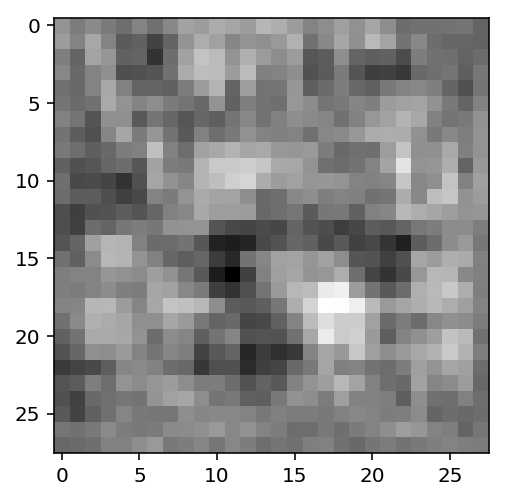

In [14]:
# try generating image

z = np.random.randn(100).reshape(1, 100)
img = G.predict([z, np.array([8])])
plt.imshow(img.reshape((28, 28)), cmap=plt.cm.gray)

In [15]:
# get our mnist data, and force it to be of shape (..., 28, 28, 1) with
# range [-1., 1.]
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

X_test = (X_test.astype(np.float32) - 127.5) / 127.5
X_test = np.expand_dims(X_test, axis=3)

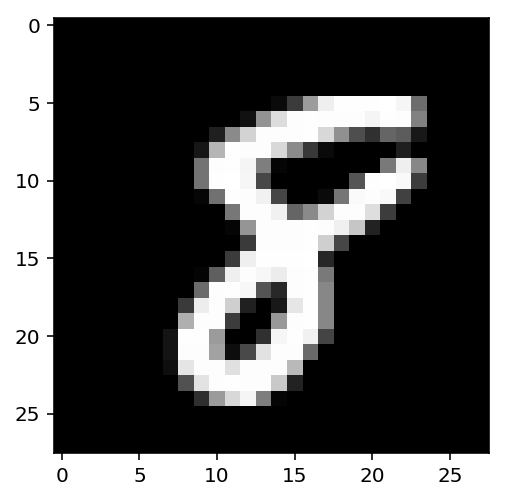

In [16]:
plt.imshow(X_train[777].reshape((28, 28)), cmap=plt.cm.gray)

In [17]:
train_num_samples, test_num_samples = X_train.shape[0], X_test.shape[0]

In [18]:
train_history = defaultdict(list)
test_history = defaultdict(list)

In [ ]:
def save_generated_samples(epoch, G):

    # new batch of z's
    zz = np.random.normal(0., 1., (100, Z_SIZE))

    # new batch of classes [0..9]
    generated_classes = np.array(list(range(10)) * 10)

    generated_images = G.predict([zz, generated_classes.reshape(-1, 1)])

    rr = []
    for c in range(10):
        rr.append(
            np.concatenate(generated_images[c * 10:(1 + c) * 10]).reshape(
                280, 28))
    img = np.hstack(rr)

    plt.imsave(OUT_DIR + '/generated-e%d.png' % epoch, img, cmap=plt.cm.gray)

In [ ]:
for epoch in range(EPOCHS):

    print('\nEpoch {} / {}'.format(epoch + 1, EPOCHS))

    batches_num = int(train_num_samples / BATCH_SIZE)
    progress_bar = Progbar(target=batches_num)

    epoch_combined_losses = []
    epoch_D_losses = []

    for batch_i in range(batches_num):

        if len(epoch_D_losses) + len(epoch_combined_losses) > 1:
            progress_bar.update(
                batch_i,
                values=[
                        ('D_is_fake_loss', np.mean(epoch_D_losses[-10:], axis=0)[1]),
                        ('D_class_loss', np.mean(epoch_D_losses[-10:], axis=0)[2]),
                        ('D(G)_is_fake_loss', np.mean(epoch_combined_losses[-10:], axis=0)[1]),
                        ('D(G)_class_loss', np.mean(epoch_combined_losses[-10:], axis=0)[2]),   
                ]
            )
        else:
            progress_bar.update(batch_i)
            
        # 1: train D on real+generated images
        
        D.trainable = True
        
        for d_it in range(D_TRAIN_ITERATIONS):

            # create batches of images and labels
            real_images = X_train[batch_i * BATCH_SIZE:(batch_i + 1) * BATCH_SIZE]
            real_images_classes = y_train[batch_i * BATCH_SIZE:(batch_i + 1) * BATCH_SIZE]

            # new batch of z's
            zz = np.random.normal(0., 1., (BATCH_SIZE, Z_SIZE))

            # new batch of classes [0..9]
            generated_classes = np.random.randint(0, 10, BATCH_SIZE)

            generated_images = G.predict([zz, generated_classes.reshape(-1, 1)])

            X = np.concatenate((real_images, generated_images))
            y_is_fake = np.array([-1] * BATCH_SIZE + [1] * BATCH_SIZE) # [is_fake=-1xBATCH_SIZE, 1xBATCH_SIZE]
            y_classes = np.concatenate((real_images_classes, generated_classes))

            # train 
            D_losses = D.train_on_batch(X, [y_is_fake, y_classes])
            epoch_D_losses.append(D_losses)

            # clip D weights

            for l in D.layers:
                weights = l.get_weights()
                weights = [np.clip(w, D_WEIGHTS_LOWER_BOUND, D_WEIGHTS_UPPER_BOUND) for w in weights]
                l.set_weights(weights)
        
        
        # 2: train D(G) (only G is trainable)
        
        D.trainable = False
        
        # xxx (2 * D_TRAIN_ITERATIONS) so G is trained for the same number of images
        # xxx as D above (which is trained on real+generated)
        zz = np.random.normal(0., 1.,  (BATCH_SIZE, Z_SIZE))
        generated_classes = np.random.randint(0, 10, BATCH_SIZE)

        y_is_fake = -np.ones(BATCH_SIZE) # all not-fake

        combined_losses = combined.train_on_batch(
            [zz, generated_classes.reshape((-1, 1))],
            [y_is_fake, generated_classes])
        
        epoch_combined_losses.append(combined_losses)
        
    print('\nD:', D.metrics_names)
    print(np.mean(np.array(epoch_D_losses), axis=0).tolist())
    
    print('D(G):', combined.metrics_names)
    print(np.mean(np.array(epoch_combined_losses), axis=0).tolist())
    
    save_generated_samples(epoch, G)


Epoch 1 / 100
936/937 [============================>.] - ETA: 0s - D_is_fake_loss: 0.0245 - D_class_loss: 1.6132 - D(G)_is_fake_loss: -55.5079 - D(G)_class_loss: 2.3859
D: ['loss', 'output_is_fake_loss', 'output_class_loss']
[1.6351512670516968, 0.022494317963719368, 1.6126571893692017]
D(G): ['loss', 'D_loss', 'D_loss']
[-53.45885467529297, -55.845436096191406, 2.386582136154175]

Epoch 2 / 100
936/937 [============================>.] - ETA: 0s - D_is_fake_loss: -5.4885e-07 - D_class_loss: 1.4739 - D(G)_is_fake_loss: -72.8872 - D(G)_class_loss: 2.4141
D: ['loss', 'output_is_fake_loss', 'output_class_loss']
[1.4738889932632446, -5.493610046869435e-07, 1.4738894701004028]
D(G): ['loss', 'D_loss', 'D_loss']
[-70.51112365722656, -72.92540740966797, 2.414242744445801]

Epoch 3 / 100
936/937 [============================>.] - ETA: 0s - D_is_fake_loss: -8.0580e-07 - D_class_loss: 1.4399 - D(G)_is_fake_loss: -77.5559 - D(G)_class_loss: 2.4146
D: ['loss', 'output_is_fake_loss', 'output_class_

936/937 [============================>.] - ETA: 0s - D_is_fake_loss: -8.0590e-07 - D_class_loss: 1.3434 - D(G)_is_fake_loss: -68.4630 - D(G)_class_loss: 2.2252
D: ['loss', 'output_is_fake_loss', 'output_class_loss']
[1.3432836532592773, -8.058750040618179e-07, 1.3432843685150146]
D(G): ['loss', 'D_loss', 'D_loss']
[-66.21944427490234, -68.44280242919922, 2.2233645915985107]

Epoch 33 / 100
660/937 [====================>.........] - ETA: 59s - D_is_fake_loss: -8.0590e-07 - D_class_loss: 1.0080 - D(G)_is_fake_loss: -76.8669 - D(G)_class_loss: 1.4987

In [ ]:
# save_generated_samples(100, G)

TODO:
    - binary crossentropy loss for D is_fake
    - detailed loss reporting